## Método de análise

Expectativas de inflação ancoradas significam que o valor dessas expectativas estejam, no horizonte relevante, próximo da meta de inflação ou mesmo constantes durante o período de referência, principalmente a do ano corrente, que tem efeito sobre os horizonte futuros. Entretanto, quando há a ocorrência de mudanças súbitas nos valores das expectativas de inflação, temos portanto, surpresas inflacionárias, e consequentemente a desancoragem de expectativas.

Para estimar uma medida de sensibilidade a surpresas inflacionárias, devemos verificar o impacto que variações nas expectativas para o ano corrente provocam sobre as expectativas para prazos mais longos. Na presença de expectativas bem ancoradas, deve haver baixa relação (co-movimento) entre as expectativas de inflação de longo prazo e as de curto prazo, em que estas últimas capturariam surpresas inflacionárias.

Em termos econométricos, essa sensibilidade é calculada a partir do coeficiente $\beta$, de acordo com a equação abaixo:

$$\Delta \pi_t^{e,h} = \alpha + \beta^h \Delta \pi_t^{e,0} + \epsilon_t$$

onde $\Delta \pi_{t}^{e,h}$ é a variação $\Delta$ da expectativa de inflação $\pi^e$ no tempo $t$ para o horizonte $h = 1, ... , 4$, em anos, para o qual foram formadas as expectativas.

Portanto, quanto maior o coeficiente $\beta$ menos ancoradas as expectativas, ou seja, maior a resposta das expectativas de longo prazo a surpresas inflacionárias. Como o interesse é na evolução deste coeficiente ao longo do tempo, as estimações são realizadas a partir de janelas móveis de 60 meses.

## Dados

O Boletim Focus permite extrair as expectativas de agentes para diferentes horizontes de diferentes indicadores, incluindo o IPCA, medida oficial de inflação no Brasil. A cada período de tempo, os agentes divulgam os valores que entendem que será o indicador no futuro em diferentes horizontes, e que tal valor, obviamente se altera, devido a mudanças de condições da economia. O Banco Central do Brasil (BCB) disponibiliza uma API para baixar os dados.

### 1. Carregamento das bibliotecas

In [25]:
from bcb import Expectativas
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from plotnine import *

### 2.  Coleta e Tratamento de dados

Vamos coletar as expectativas anuais do IPCA. Em seguida, devemos definir os horizontes com base na data de referência. Retiramos a média do valor da mediana para os respectivos meses agrupados por horizontes. E por fim, obtemos o delta de cada horizonte, isto é, a diferença entre o valor do horizonte no tempo t e do tempo t-1.

In [2]:
# Instância a classe de Expectativas
em = Expectativas()

# Obtém o endpoint da Expectativa de Mercado Anuais
exp_ipca_endpoint = em.get_endpoint("ExpectativasMercadoAnuais")

# Expectativa média do IPCA - tx. anual (Expectativas)
exp_ipca_raw = (
    exp_ipca_endpoint
    .query()
    .filter(exp_ipca_endpoint.baseCalculo == 0,
            exp_ipca_endpoint.Indicador == "IPCA",
            exp_ipca_endpoint.Data >= "2002-01-01")
    .collect()
    )

In [3]:
# Realiza a filtragem e define os horizontes
exp_ipca_h = (
    exp_ipca_raw
    .filter(items = ["Data", "DataReferencia", "Mediana"], axis = "columns")
    .assign(
      Data = lambda x : pd.to_datetime(x.Data),
      DataReferencia = lambda x: x.DataReferencia.astype(int),
      h = lambda x: np.select([
        x["Data"].dt.year == x["DataReferencia"],
        x["Data"].dt.year == x["DataReferencia"] - 1,
        x["Data"].dt.year == x["DataReferencia"] - 2,
        x["Data"].dt.year == x["DataReferencia"] - 3,
        x["Data"].dt.year == x["DataReferencia"] - 4
        ],
        ["h0", "h1", "h2", "h3", "h4"]
        ),
      Year = lambda x: x["Data"].dt.year,
      Month = lambda x: x["Data"].dt.month
    )
    .query("h != '0'")
)

In [4]:
# Agrega dados
expec_ipca = (
     exp_ipca_h
    .assign(data = lambda x: x.Data.dt.to_period(freq = "M").dt.to_timestamp())
    .groupby(by = ["data", "h"], as_index = False) 
    .agg(Mediana = ("Mediana", "mean"))
  )

In [5]:
# Calcula o delta (diferença do tempo t com o tempo t-1)
expec_ipca_diff = (
    expec_ipca
    .pivot(index = "data", columns = "h", values = "Mediana")
    .diff()
    .dropna()
  )

### 3. Criação do Modelo

Para obter o coeficiente $\beta$ em janelas deslizantes de 60 meses será necessário utilizar a função `RollingOLS` da biblioteca `statsmodels`.

Em relação a especificação, podemos obter a surpresa inflacionária para os diferentes horizontes, portanto, para obter o resultado de todas as combinações possíveis, usaremos um `for loop` para as fórmulas. 

In [9]:
# Define variável independente e variáveis dependentes
X = expec_ipca_diff["h0"]
Y_cols = ["h1", "h2", "h3", "h4"]

# Define tamanho da janela de regressão
k = 60

# Cria lista para armazenar os resultados das regressões
results = []

# Loop para ajustar os modelos de regressão
for col in Y_cols:
    # Define fórmula da regressão
    formula = f"{col} ~ h0"
    
    # Cria o objeto RollingOLS
    model_rolling = RollingOLS.from_formula(
      formula = formula,
      data = expec_ipca_diff,
      window = k
      )
    
    # Calcula as rolling regressions
    rolling_res = model_rolling.fit()

    # Salva os resultados das regressões
    results.append(rolling_res.params)

# Juntar os resultados das regressões em um único dataframe
results_df = pd.concat(results, axis = 0, keys = Y_cols)

In [35]:

# Captura somente o beta da regressão
# Assuming results_df is already defined
beta = (
    results_df
    .reset_index()
    .rename(columns={"level_0": "variables", "h0": "beta"})
    .dropna()
    .filter(items=["data", "variables", "beta"], axis="columns")
    .assign(
        variables=lambda x: np.select(
            [
                x.variables == "h1",
                x.variables == "h2",
                x.variables == "h3",
                x.variables == "h4"
            ],
            [
                "Expectativa 1 ano",
                "Expectativa 2 anos",
                "Expectativa 3 anos",
                "Expectativa 4 anos"
            ],
            default=x.variables
        )
    )
)
beta_data = pd.DataFrame(beta)
beta_data

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\pedro\AppData\Roaming\Python\Python311\site-packages\IPython\core\formatters.py", line 221, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pedro\AppData\Roaming\Python\Python311\site-packages\IPython\core\formatters.py", line 342, in __call__
    return method()
           ^^^^^^^^
  File "c:\Users\pedro\anaconda3\Lib\site-packages\pandas\core\frame.py", line 1175, in _repr_html_
    # check whether repr fits horizontal by actually checking
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pedro\anaconda3\Lib\site-packages\pandas\io\formats\format.py", line 1074, in to_html
  File "c:\Users\pedro\anaconda3\Lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  File "c:\Users\pedro\anaconda3\Lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().rende

           data           variables      beta
59   2007-01-01   Expectativa 1 ano  0.602037
60   2007-02-01   Expectativa 1 ano  0.602117
61   2007-03-01   Expectativa 1 ano  0.602447
62   2007-04-01   Expectativa 1 ano  0.605620
63   2007-05-01   Expectativa 1 ano  0.605380
...         ...                 ...       ...
1071 2024-02-01  Expectativa 4 anos  0.008225
1072 2024-03-01  Expectativa 4 anos  0.008225
1073 2024-04-01  Expectativa 4 anos  0.008235
1074 2024-05-01  Expectativa 4 anos  0.008286
1075 2024-06-01  Expectativa 4 anos  0.008319

[840 rows x 3 columns]

### 4. Visualização de dados

Enfim podemos visualizar o coeficiente $\beta$ para cada horizonte ao longo de diferentes mandatos de presidentes do Banco Central e realizar uma análise.

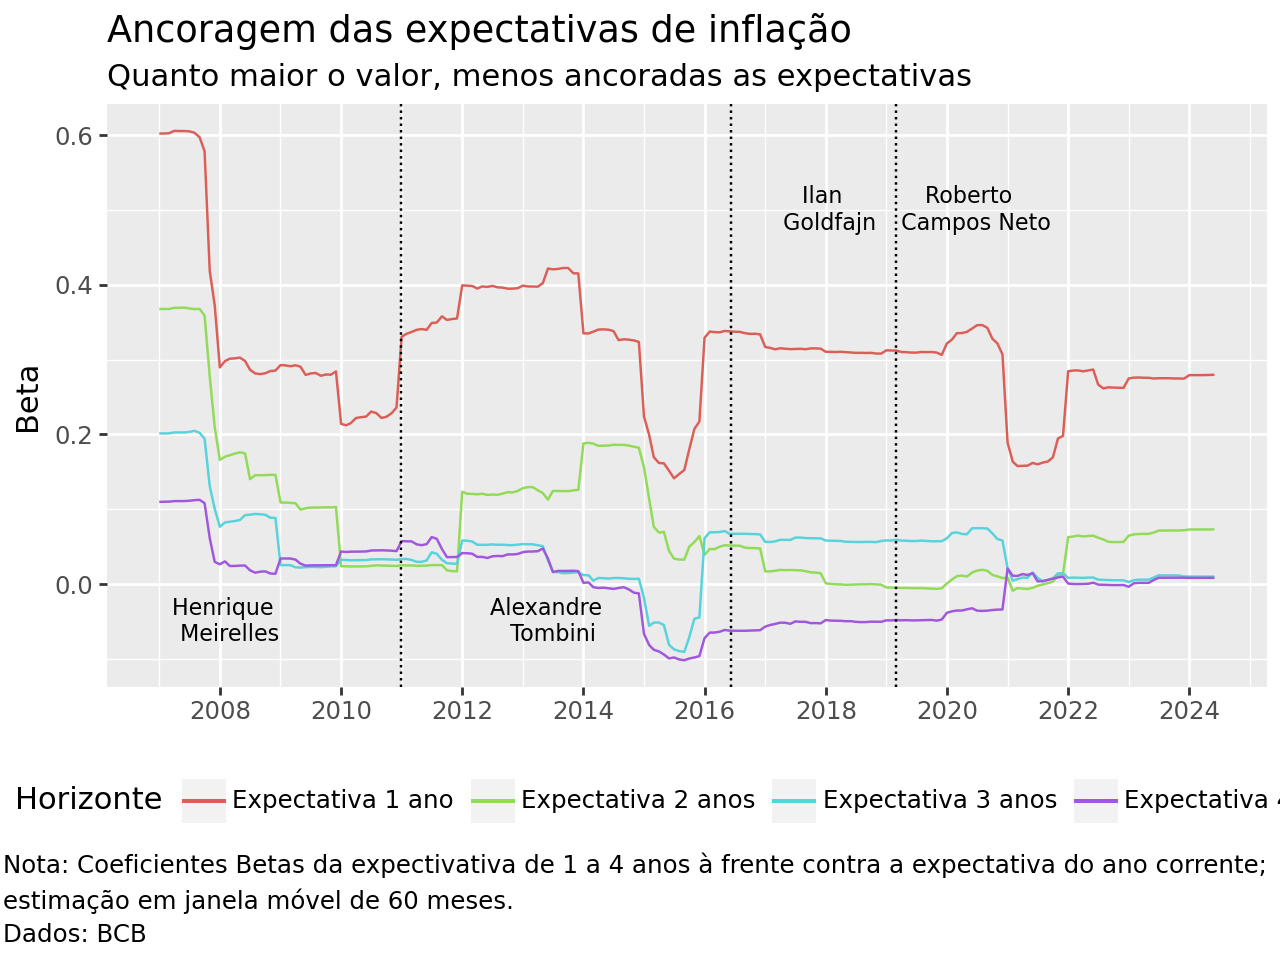

In [36]:
# Criação do gráfico
(
  ggplot(beta) +
  aes(x = "data", y = "beta", color = "variables") +
  geom_line() +
  scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  geom_vline(
    xintercept = ["2010-12-31", "2016-06-09", "2019-02-28"], 
    linetype = "dotted"
    ) +
  annotate(
    geom = "text",
    x = "2008-02-09",
    y = -0.05,
    label = "Henrique \n Meirelles",
    size = 8
    ) +
  annotate(
    geom = "text",
    x = "2013-06-09",
    y = -0.05,
    label = "Alexandre \n Tombini",
    size = 8
    ) +
  annotate(
    geom = "text",
    x = "2018-01-01",
    y = 0.5,
    label = "Ilan \n Goldfajn",
    size = 8
    ) +
  annotate(
    geom = "text",
    x = "2020-06-01",
    y = 0.5,
    label = "Roberto \n Campos Neto",
    size = 8
    ) +
  labs(
    title = "Ancoragem das expectativas de inflação",
    subtitle = "Quanto maior o valor, menos ancoradas as expectativas",
    color = "Horizonte",
    x = "",
    y = "Beta",
    caption = (
      "Nota: Coeficientes Betas da expectivativa de 1 a 4 anos à frente contra a expectativa do ano corrente;\nestimação em janela móvel de " + str(k) + " meses.\n" +
      "Dados: BCB"
      )
    ) +
  theme(
    legend_position = "bottom", 
    legend_box_margin = 5,
    plot_caption = element_text(linespacing = 1.5)
    )
)